## Flowers Image Classification using a Linear Model

In this notebook, we will use a creative-commons licensed flower photo dataset
containing **3,670 images** across **5 categories**:

- daisy
- dandelion
- roses
- sunflowers
- tulips

Rather than relying on cloud storage, we will load this dataset locally using
`tensorflow_datasets`, which provides a standardized and reproducible way to
access common machine learning datasets.

The dataset will be:
- Downloaded once (if not already cached)
- Stored locally in the `data/tfds/` directory
- Split into training (80%) and validation (20%) subsets

This setup allows the notebook to run fully offline after the initial download
and ensures consistent results across student machines.


In [1]:
# ========================================================
# Step 0: Imports and environment setup
# ========================================================
from pathlib import Path
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import array_to_img

tf.random.set_seed(42)

# Local TFDS dataset directory
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# ========================================================
# Step 1: Load the TF Flowers dataset
# ========================================================
(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True,
    data_dir=DATA_DIR / "tfds"
)

CLASS_NAMES = ds_info.features["label"].names
NUM_CLASSES = ds_info.features["label"].num_classes

print(f"Number of classes: {NUM_CLASSES}")
print("Class names:", CLASS_NAMES)
print(f"Training samples: {ds_info.splits['train'].num_examples}")
print(f"Validation samples: {ds_info.splits['train'].num_examples * 0.2:.0f}")


Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Training samples: 3670
Validation samples: 734


In [2]:
# ========================================================
# Step 2a: Try reading and displaying one of the files
# ======================================================== 
# TFDS is in TFRecord format (a binary stream of individual pictures), so we treat datasets as streams of examples, not collections of files. 
# TFDS handles file storage, decoding, and caching so we can focus on modeling
# We use TensorFlow’s built-in image utilities for visualization to ensure stability across machines
print("\n--- Displaying one image example ---")
for image, label in ds_train.take(1):
    tf.keras.utils.array_to_img(image).show(
        title=CLASS_NAMES[int(label)]
    )




--- Displaying one image example ---


2026-02-11 19:42:51.134004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2026-02-11 19:42:51.332864: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [3]:
# ========================================================
# Step 2b: Display some tulips
# ======================================================== 
print("\n--- Displaying some tulips example ---")
TULIP_LABEL = CLASS_NAMES.index("tulips")
tulip_ds = ds_train.filter(lambda image, label: label == TULIP_LABEL)
for image, label in tulip_ds.take(5):
    array_to_img(image).show(title=CLASS_NAMES[int(label)])



--- Displaying some tulips example ---


2026-02-11 19:43:00.760915: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
# ========================================================
# Step 2c: TFDS gives labels directly, so no string parsing is needed
# ========================================================
for image, label in ds_train.take(1):
    flower_name = CLASS_NAMES[int(label)]
    print(flower_name)


tulips


2026-02-11 19:43:10.171655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
# ========================================================
# Step 2d: Display one example per class 
# ========================================================
print("\n--- Displaying one example per class ---")
for idx, class_name in enumerate(CLASS_NAMES):
    class_ds = ds_train.filter(lambda img, lbl: lbl == idx)
    for image, label in class_ds.take(1):
        array_to_img(image).show(title=class_name)



--- Displaying one example per class ---


2026-02-11 19:43:14.944966: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2026-02-11 19:43:15.061055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2026-02-11 19:43:15.196220: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

## A simple rule-based model

Let's get the average color of RGB values in the different
types of flowers and then classify an unknown image as
belonging to closest centroid.

In [6]:
# ========================================================
# Step 3: Compute average RGB per image (rule-based centroid)
# ========================================================
print("\n--- Computing per-image average RGB for a few examples ---")
for image, label in ds_train.take(3):
    avg_color = tf.reduce_mean(tf.cast(image, tf.float32), axis=[0, 1])
    print(CLASS_NAMES[int(label)], avg_color.numpy())



--- Computing per-image average RGB for a few examples ---
tulips [157.62529   72.94888   32.309303]
sunflowers [83.382484 57.07089  20.407503]
sunflowers [127.15595 142.68591  96.15909]


2026-02-11 19:43:26.186345: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
# ========================================================
# Step 4a: Define Centroid and CentroidRule classes
# ========================================================
class Centroid:
    def __init__(self, label):
        self.label = label
        self.sum_so_far = tf.constant(0., dtype=tf.float32)
        self.count_so_far = 0

    def update(self, value):
        self.sum_so_far += value
        self.count_so_far += 1
        if self.count_so_far % 100 == 0:
            print(self.label, self.count_so_far)

    def centroid(self):
        return self.sum_so_far / self.count_so_far

    def __str__(self):
        return f'{self.label} {self.centroid().numpy()}'

class CentroidRule:
    def __init__(self):
        self.centroids = {f: Centroid(f) for f in CLASS_NAMES}

    def fit(self, dataset):
        for img, label in dataset:
            label_name = CLASS_NAMES[int(label)]
            avg = tf.reduce_mean(tf.cast(img, tf.float32), axis=[0, 1])
            self.centroids[label_name].update(avg)

    def predict(self, img):
        avg = tf.reduce_mean(tf.cast(img, tf.float32), axis=[0, 1])
        best_label = ""
        best_diff = 999
        for key, val in self.centroids.items():
            diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
            if diff < best_diff:
                best_diff = diff
                best_label = key
        return best_label

    def evaluate(self, dataset):
        num_correct, total_images = 0, 0
        for img, label in dataset:
            correct = CLASS_NAMES[int(label)]
            predicted = self.predict(img)
            if correct == predicted:
                num_correct += 1
            total_images += 1
        accuracy = num_correct / total_images
        return accuracy


In [8]:
# ========================================================
# Step 4b: Fit centroid classifier on small subsets (fast demo)
# ========================================================
train_subset = ds_train.take(500)  # speed demo
eval_subset = ds_val.take(50)      # speed demo

rule = CentroidRule()
rule.fit(train_subset)

print("\n--- Inspect some centroids ---")
print("Centroid for daisy:", rule.centroids['daisy'])
print("Centroid for roses:", rule.centroids['roses'])


dandelion 100
tulips 100

--- Inspect some centroids ---
Centroid for daisy: daisy [104.131424 110.32676   87.702705]
Centroid for roses: roses [128.12213  96.59749  88.90876]


2026-02-11 19:43:30.136164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
# ========================================================
# Step 4c: Evaluate classifier on small validation subset
# ========================================================
accuracy = rule.evaluate(eval_subset)
print("\nAccuracy on eval subset:", accuracy)



Accuracy on eval subset: 0.36


2026-02-11 19:43:31.934356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
# ========================================================
# Step 5a: This is how you'd use the model to predict
# ======================================================== 
# Take one example from the validation set
for img, label in ds_val.take(1):
    predicted_label = rule.predict(img)
    true_label = CLASS_NAMES[int(label)]
    print("True label:     ", true_label)
    print("Predicted label:", predicted_label)

    # Optionally display the image
    from tensorflow.keras.utils import array_to_img
    array_to_img(img).show(title=f"Predicted: {predicted_label}")


True label:      roses
Predicted label: dandelion


2026-02-11 19:43:33.816231: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
# ========================================================
# Step 5b: Predicting a small batch from the validation set
# ======================================================== 
# Take a small batch of images (e.g., 5 images)
batch_size = 5
for idx, (img, label) in enumerate(ds_val.take(batch_size)):
    predicted_label = rule.predict(img)
    true_label = CLASS_NAMES[int(label)]
    
    print(f"Example {idx+1}")
    print("  True label:     ", true_label)
    print("  Predicted label:", predicted_label)
    
    # Display the image safely
    array_to_img(img).show(title=f"Predicted: {predicted_label}")


Example 1
  True label:      roses
  Predicted label: dandelion
Example 2
  True label:      tulips
  Predicted label: dandelion
Example 3
  True label:      tulips
  Predicted label: dandelion
Example 4
  True label:      tulips
  Predicted label: roses
Example 5
  True label:      daisy
  Predicted label: dandelion


2026-02-11 19:43:44.743207: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## A linear model

In [12]:
# ========================================================
# Step 6: Prepare datasets for linear model
# ========================================================
BATCH_SIZE = 10
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3

def preprocess(img, label):
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, label

train_dataset = ds_train.map(preprocess).batch(BATCH_SIZE)
eval_dataset = ds_val.map(preprocess).batch(BATCH_SIZE)

In [13]:
# ========================================================
# Step 7: Define linear model
# ========================================================
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [14]:
# ========================================================
# Step 8: Train the linear model
# ========================================================
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=10
)

Epoch 1/10
294/294 [==============================] - 1s 3ms/step - loss: 5239.3555 - accuracy: 0.3403 - val_loss: 3879.8457 - val_accuracy: 0.4346
Epoch 2/10
294/294 [==============================] - 1s 2ms/step - loss: 3725.2148 - accuracy: 0.4009 - val_loss: 6249.5054 - val_accuracy: 0.3597
Epoch 3/10
294/294 [==============================] - 1s 2ms/step - loss: 3874.2468 - accuracy: 0.4530 - val_loss: 5180.4702 - val_accuracy: 0.3924
Epoch 4/10
294/294 [==============================] - 1s 2ms/step - loss: 3605.7043 - accuracy: 0.4779 - val_loss: 7689.8984 - val_accuracy: 0.3774
Epoch 5/10
294/294 [==============================] - 1s 2ms/step - loss: 4398.9917 - accuracy: 0.4843 - val_loss: 6242.5151 - val_accuracy: 0.4223
Epoch 6/10
294/294 [==============================] - 1s 2ms/step - loss: 2767.6624 - accuracy: 0.5521 - val_loss: 3568.3718 - val_accuracy: 0.4319
Epoch 7/10
294/294 [==============================] - 1s 2ms/step - loss: 4119.6450 - accuracy: 0.5119 - val_los

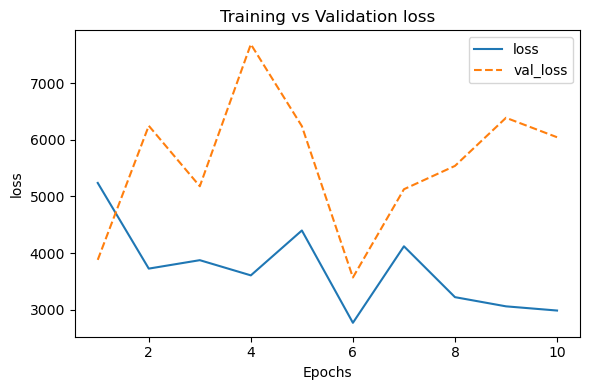

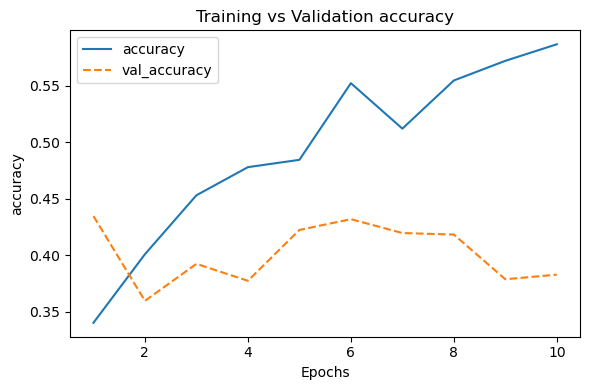

In [15]:
# ========================================================
# Step 9: Plot training curves
# ========================================================
def training_plot_stream(history, metrics=['loss','accuracy']):
    for metric in metrics:
        y_train = history.history[metric]
        y_val = history.history['val_' + metric]

        # Create simple list-based plot
        plt.figure(figsize=(6,4))
        plt.plot(list(range(1, len(y_train)+1)), y_train, label=metric)
        plt.plot(list(range(1, len(y_val)+1)), y_val, linestyle='dashed', label='val_' + metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(f"Training vs Validation {metric}")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()  # release memory immediately

training_plot_stream(history)

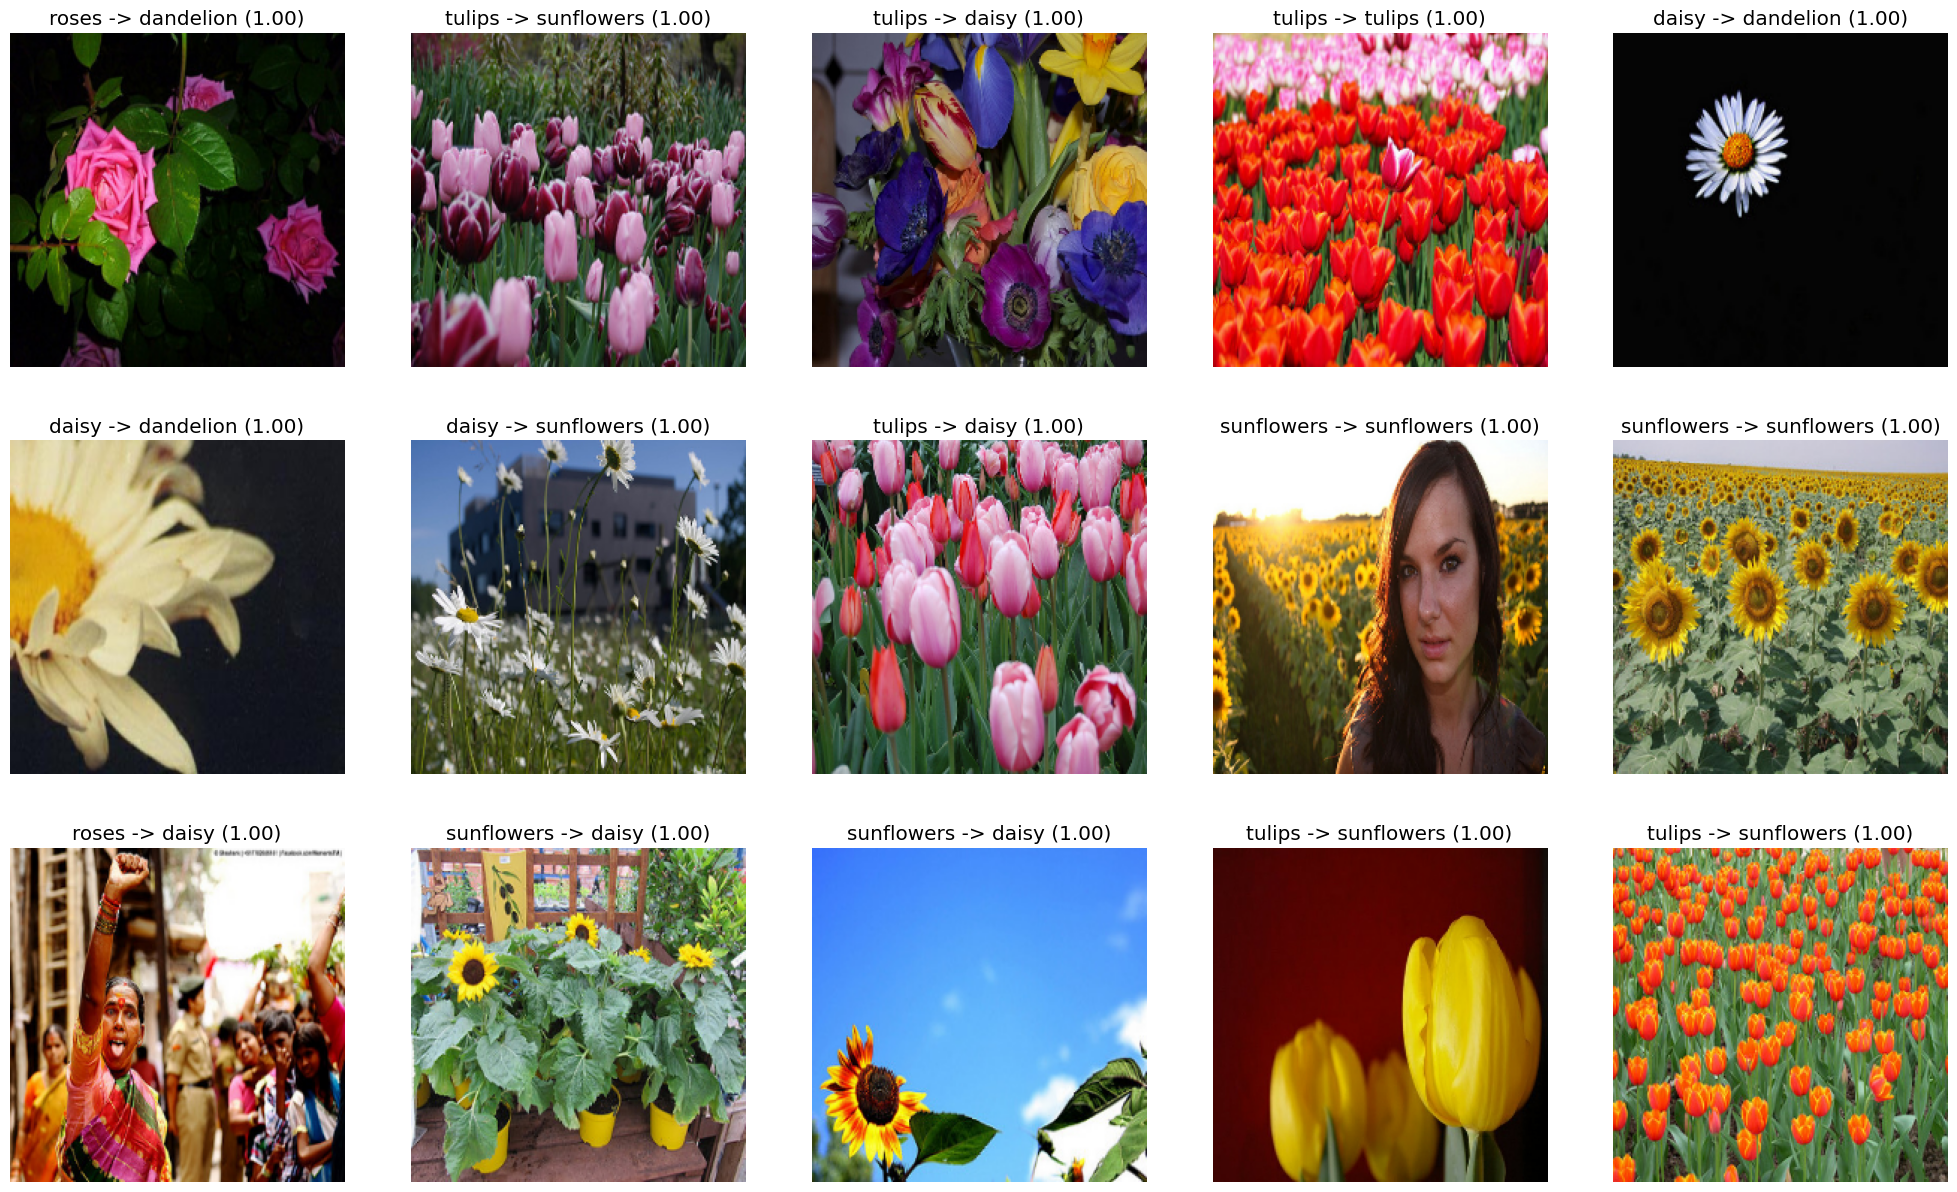

In [16]:
# ========================================================
# Step 10: Predict on a few images with linear model
# ========================================================
def plot_predictions(dataset, num_images=15):
    plt.rcParams.update({'font.size': 12})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.unbatch().take(num_images)):
        batch_img = tf.expand_dims(img, 0)
        pred = model.predict(batch_img, verbose=0)[0]
        pred_label_index = tf.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        true_label = CLASS_NAMES[int(label)]

        ax[idx//5, idx%5].imshow(img.numpy().astype("uint8"))
        ax[idx//5, idx%5].set_title(f"{true_label} -> {pred_label} ({pred[pred_label_index]:.2f})")
        ax[idx//5, idx%5].axis('off')

plot_predictions(eval_dataset)

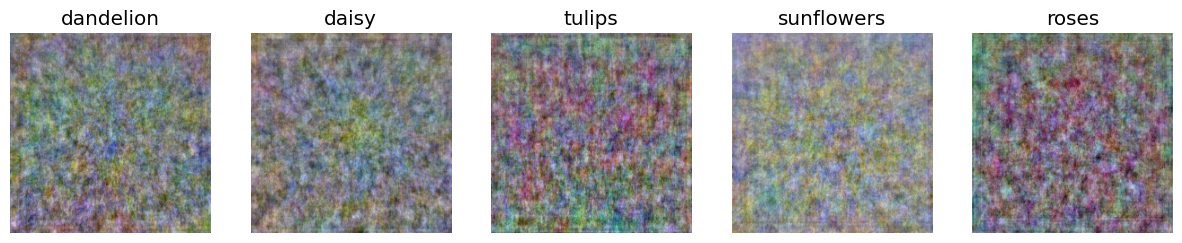

In [17]:
# ========================================================
# Step 11: Visualize trained linear weights
# ========================================================
def show_trained_weights(model):
    WEIGHT_TYPE = 0  # 0 = weight
    LAYER = 1        # Dense layer

    f, ax = plt.subplots(1, NUM_CLASSES, figsize=(15,15))
    for flower in range(NUM_CLASSES):
        weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
        min_wt = tf.reduce_min(weights).numpy()
        max_wt = tf.reduce_max(weights).numpy()
        weights = (weights - min_wt) / (max_wt - min_wt)
        ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        ax[flower].set_title(CLASS_NAMES[flower])
        ax[flower].axis('off')

show_trained_weights(model)


## Diagrams


[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.         0.19999999 0.59999996 0.19999999 0.        ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


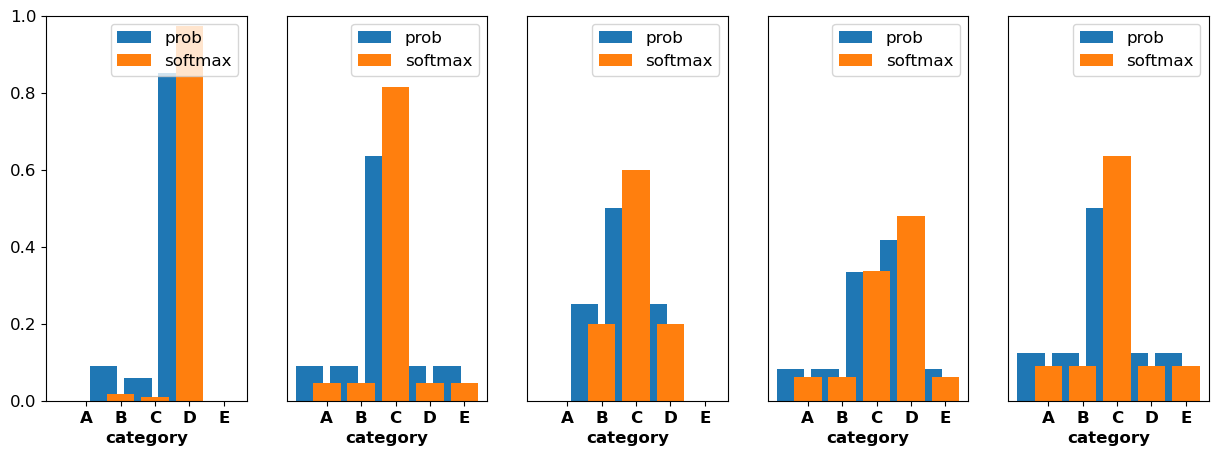

In [18]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()